# Trying some preliminary linear regression modeling approaches for individual genes in OM-RGC



# First get the environmental data together

## Work on data from sample collection first

The TARA Sunagawa et al. publication very helpfully compiled this into an excel spreadsheet for us. There are multiple tabs, so I converted the relevant tabs into csv files. W8 is MetadataTableW8.csv

In [66]:
import pandas as pd, sklearn as skl, numpy as np, ggplot as gg, random, pickle, matplotlib.pyplot as plt
from sklearn import *
from ggplot import *
%matplotlib inline


In [2]:
env = pd.read_csv("MetadataTableW8.csv",nrows=243)
env.head()


,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,Mean_Nitrates[umol/L]*,NO2 [umol/L]**,...,miTAG.SILVA.ace,miTAG.SILVA.Shannon,OG.Shannon,OG.Richness,OG.Evenness,FC - heterotrophs [cells/mL],FC - autotrophs [cells/mL],FC - bacteria [cells/mL],FC - picoeukaryotes [cells/mL],minimum generation time [h]
0,TARA_B100000965,4/15/11 13:10,-12.99,-95.99,57.6,20.6,35.5,216.8,1.5,0.16,...,4230,6.83,7.25,18465,0.738,384276,116141,500417,4501,14
1,TARA_B100000959,4/16/11 16:09,-12.93,-96.12,175.3,13.0,34.8,0.7,21.1,0.03,...,4686,6.68,7.23,17448,0.740,305319,0,305319,0,26
2,TARA_B100000963,4/15/11 13:10,-12.99,-95.99,5.5,25.3,35.8,200.2,4.6,0.14,...,3459,6.60,7.17,14283,0.749,464267,155789,620056,7780,14
3,TARA_B100000902,4/22/11 19:51,-5.27,-85.23,45.7,19.6,34.9,103.9,20.3,1.20,...,4111,6.78,7.17,15878,0.741,1071414,246947,1318361,13382,12
4,TARA_B100000953,4/22/11 14:16,-5.27,-85.22,475.6,9.2,34.7,4.4,40.0,0.01,...,4643,6.68,7.19,17457,0.736,162019,0,162019,0,27


We'll also need to associate the data from the metadata table, containing a PANGEA ID, with its sample ID from W1.


In [3]:
samples = pd.read_csv("SampleDescriptionTableMunged.csv")


In [4]:
samples.head()


,sample.label,INSDC.sample.id,INSDC.run.id.s,PANGAEA.sample.id,stn,latN,longE,sample.depth.m,depth.id,size.frac.lower,size.frac.upper,longhurst.biome,marine.region,pelagic.biome
0,TARA_004_DCM_0.22-1.6,ERS487936,ERR598950|ERR599095,TARA_X000000368,TARA_004,36.5533,-6.5669,40,DCM,0.22,1.6,Westerlies,NAO,NASTE
1,TARA_004_SRF_0.22-1.6,ERS487899,ERR598955|ERR599003,TARA_Y200000002,TARA_004,36.5533,-6.5669,5,SRF,0.22,1.6,Westerlies,NAO,NASTE
2,TARA_007_DCM_0.22-1.6,ERS477953,ERR315856,TARA_A200000159,TARA_007,37.0541,1.9478,42,DCM,0.22,1.6,Westerlies,MS,MEDI
3,TARA_007_SRF_0.22-1.6,ERS477931,ERR315857,TARA_A200000113,TARA_007,37.0510,1.9378,5,SRF,0.22,1.6,Westerlies,MS,MEDI
4,TARA_009_DCM_0.22-1.6,ERS488147,ERR594315|ERR594329,TARA_X000001036,TARA_009,39.0609,5.9422,55,DCM,0.22,1.6,Westerlies,MS,MEDI


### Subset only prokaryotic samples

In [5]:
#make sample description table for prokaryotes only
prok = samples.loc[(samples["size.frac.lower"]=="0.22") & ((samples["size.frac.upper"]==1.60) | (samples["size.frac.upper"]==3.00))]
#remove four datapoints sampled at inconsistent depths (not SRF, DCM, or MES, labeled "NaN") 
prok = prok.drop(prok.index[[99,101,103,137]])
#now have 135 samples left. 
prok.head()


,sample.label,INSDC.sample.id,INSDC.run.id.s,PANGAEA.sample.id,stn,latN,longE,sample.depth.m,depth.id,size.frac.lower,size.frac.upper,longhurst.biome,marine.region,pelagic.biome
0,TARA_004_DCM_0.22-1.6,ERS487936,ERR598950|ERR599095,TARA_X000000368,TARA_004,36.5533,-6.5669,40,DCM,0.22,1.6,Westerlies,NAO,NASTE
1,TARA_004_SRF_0.22-1.6,ERS487899,ERR598955|ERR599003,TARA_Y200000002,TARA_004,36.5533,-6.5669,5,SRF,0.22,1.6,Westerlies,NAO,NASTE
2,TARA_007_DCM_0.22-1.6,ERS477953,ERR315856,TARA_A200000159,TARA_007,37.0541,1.9478,42,DCM,0.22,1.6,Westerlies,MS,MEDI
3,TARA_007_SRF_0.22-1.6,ERS477931,ERR315857,TARA_A200000113,TARA_007,37.0510,1.9378,5,SRF,0.22,1.6,Westerlies,MS,MEDI
4,TARA_009_DCM_0.22-1.6,ERS488147,ERR594315|ERR594329,TARA_X000001036,TARA_009,39.0609,5.9422,55,DCM,0.22,1.6,Westerlies,MS,MEDI


### Merge prokaryote sample labels with metadata

In [6]:
metadata = prok[["sample.label","PANGAEA.sample.id"]].merge(env,left_on="PANGAEA.sample.id",right_on="PANGAEA Sample ID",how="inner")
#drop redundant pangaea sample id column from merge
metadata.drop("PANGAEA.sample.id",axis=1,inplace=True)
print(metadata.columns.values)
metadata.head()


['sample.label' 'PANGAEA Sample ID' 'Mean_Date [YY/MM/DD hh:mm]*'
 'Mean_Lat*' 'Mean_Long*' 'Mean_Depth [m]*' 'Mean_Temperature [deg C]*'
 'Mean_Salinity [PSU]*' 'Mean_Oxygen [umol/kg]*' 'Mean_Nitrates[umol/L]*'
 'NO2 [umol/L]**' 'PO4 [umol/L]**' 'NO2NO3 [umol/L]**' 'SI [umol/L]**'
 'AMODIS:PAR8d,Einsteins/m-2/d-1' 'Okubo-Weiss' 'Lyapunov_exp.'
 'grad_SST_adv' 'retention' 'Mean Depth MLD Sigma [m]*'
 'Mean Depth Max Fluo [m]*' 'Mean Depth Max N2 [m]*'
 'Mean Depth Max O2 [m]*' 'Mean Depth Min O2 [m]*'
 'Mean Depth Nitracline [m]*' 'miTAG.SILVA.Taxo.Richness'
 'miTAG.SILVA.Phylo.Diversity' 'miTAG.SILVA.Chao' 'miTAG.SILVA.ace'
 'miTAG.SILVA.Shannon' 'OG.Shannon' 'OG.Richness' 'OG.Evenness'
 'FC - heterotrophs [cells/mL]' 'FC - autotrophs [cells/mL]'
 'FC - bacteria [cells/mL]' 'FC - picoeukaryotes [cells/mL]'
 'minimum generation time [h]']


,sample.label,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,Mean_Nitrates[umol/L]*,...,miTAG.SILVA.ace,miTAG.SILVA.Shannon,OG.Shannon,OG.Richness,OG.Evenness,FC - heterotrophs [cells/mL],FC - autotrophs [cells/mL],FC - bacteria [cells/mL],FC - picoeukaryotes [cells/mL],minimum generation time [h]
0,TARA_004_DCM_0.22-1.6,TARA_X000000368,9/15/09 16:45,36.57,-6.54,38.7,16.2,36.6,NaN,NaN,...,4030,6.85,7.16,14607,0.747,1226212,56383,1282596,6890,11
1,TARA_004_SRF_0.22-1.6,TARA_Y200000002,9/15/09 10:15,36.55,-6.57,10.0,20.5,36.6,NaN,NaN,...,3680,6.64,7.15,14591,0.745,839531,54593,894124,1222,15
2,TARA_007_DCM_0.22-1.6,TARA_A200000159,9/23/09 16:52,37.04,1.95,41.7,17.4,NaN,NaN,NaN,...,4585,6.80,7.28,16417,0.750,2580789,156125,2736914,1859,14
3,TARA_007_SRF_0.22-1.6,TARA_A200000113,9/23/09 15:06,37.02,1.95,7.5,23.8,37.5,NaN,NaN,...,3729,6.53,7.20,15495,0.746,1004684,50586,1055270,813,14
4,TARA_009_DCM_0.22-1.6,TARA_X000001036,9/28/09 13:36,39.07,5.86,55.0,16.2,37.8,NaN,NaN,...,4297,6.91,7.15,15318,0.742,781039,19832,800871,2882,11


#### There are some missing labels in the metadata. There are a few columns that are the main culprit of this. 

I'll remove those columns so as to have as many datapoints as possible

In [7]:
for column in metadata.columns.values:
    #print how many complete cases there are for each column, out of 135
    clean = metadata[column].dropna(axis=0)
    print(len(clean), column)

(135, 'sample.label')
(135, 'PANGAEA Sample ID')
(135, 'Mean_Date [YY/MM/DD hh:mm]*')
(135, 'Mean_Lat*')
(135, 'Mean_Long*')
(135, 'Mean_Depth [m]*')
(135, 'Mean_Temperature [deg C]*')
(132, 'Mean_Salinity [PSU]*')
(129, 'Mean_Oxygen [umol/kg]*')
(109, 'Mean_Nitrates[umol/L]*')
(127, 'NO2 [umol/L]**')
(127, 'PO4 [umol/L]**')
(127, 'NO2NO3 [umol/L]**')
(127, 'SI [umol/L]**')
(111, 'AMODIS:PAR8d,Einsteins/m-2/d-1')
(124, 'Okubo-Weiss')
(130, 'Lyapunov_exp.')
(69, 'grad_SST_adv')
(130, 'retention')
(135, 'Mean Depth MLD Sigma [m]*')
(135, 'Mean Depth Max Fluo [m]*')
(135, 'Mean Depth Max N2 [m]*')
(129, 'Mean Depth Max O2 [m]*')
(129, 'Mean Depth Min O2 [m]*')
(117, 'Mean Depth Nitracline [m]*')
(135, 'miTAG.SILVA.Taxo.Richness')
(135, 'miTAG.SILVA.Phylo.Diversity')
(135, 'miTAG.SILVA.Chao')
(135, 'miTAG.SILVA.ace')
(135, 'miTAG.SILVA.Shannon')
(135, 'OG.Shannon')
(135, 'OG.Richness')
(135, 'OG.Evenness')
(121, 'FC - heterotrophs [cells/mL]')
(124, 'FC - autotrophs [cells/mL]')
(124, 'FC 

In [8]:
#columns to remove: the only one I think might matter is PAR, but we have a lot of features anyway and I'd rather keep more observations for now
to_drop = ["grad_SST_adv","Mean_Nitrates[umol/L]*","AMODIS:PAR8d,Einsteins/m-2/d-1","Mean Depth Nitracline [m]*","Okubo-Weiss"]
#?pd.DataFrame.drop
metadata_clean = metadata.drop(labels=to_drop,axis=1) 
metadata_clean2 = metadata_clean.dropna(axis=0)
print(len(metadata_clean2)) # there's now 107 observations to work with
metadata_clean2.head()

107


,sample.label,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,NO2 [umol/L]**,...,miTAG.SILVA.ace,miTAG.SILVA.Shannon,OG.Shannon,OG.Richness,OG.Evenness,FC - heterotrophs [cells/mL],FC - autotrophs [cells/mL],FC - bacteria [cells/mL],FC - picoeukaryotes [cells/mL],minimum generation time [h]
7,TARA_018_SRF_0.22-1.6,TARA_A100000164,11/2/09 8:18,35.76,14.26,5.4,21.4,37.9,207.8,0.02,...,3931,6.61,7.14,14161,0.747,633618,39180,672798,947,14
8,TARA_023_DCM_0.22-1.6,TARA_E500000081,11/18/09 12:42,42.17,17.72,55.2,15.7,38.4,224.3,0.01,...,3974,6.74,7.15,15924,0.739,594712,29838,624550,1090,17
9,TARA_023_SRF_0.22-1.6,TARA_E500000075,11/18/09 8:23,42.21,17.71,5.5,17.6,38.2,220.0,0.01,...,3632,6.58,7.13,14477,0.745,746759,57854,804613,1499,18
11,TARA_025_SRF_0.22-1.6,TARA_E500000178,11/23/09 9:14,39.39,19.39,5.5,18.3,38.2,218.0,0.00,...,3635,6.71,7.17,14408,0.749,264404,34000,298404,1123,21
12,TARA_030_DCM_0.22-1.6,TARA_A100001011,12/15/09 16:17,33.93,32.77,69.1,19.0,39.3,218.1,0.01,...,3170,6.56,7.14,12843,0.755,598682,48034,646716,669,15


## Now bring in count data. 

### The original file is 40GB and there are 40M genes. For this preliminary look, I'll look at 1% of the data, or 400,000 genes. I *could* train models on all of them, but that seems like overkill for this preliminary exploration, plus I don't have 40GB of RAM without using the cluster.

### These are *length-normalized* base counts for each gene in the OM-RGC, provided by S. Sunagawa. 

The count table can be downloaded at [this url](http://ocean-microbiome.embl.de/data/TARA243.gene.profile.release.gz). Unzipped it's about 40GB.

I still think there's value in producing our own counts, but for the purposes of this analysis I'll accept Sunagawa et al.'s counts for now.


In [9]:
#read in only the samples defined in prok df, will use less mem
#for debugging code, only going to read in 
counts = pd.read_csv("OMRGC_counts_test.txt",delim_whitespace=True,index_col="OM-RGC_ID",usecols=np.append("OM-RGC_ID",np.array(metadata["sample.label"])))
#transpose the table so that genes are the columns, sites are the rows
counts = counts.transpose()
counts.head()


OM-RGC_ID,OM-RGC.v1.005042799,OM-RGC.v1.017507904,OM-RGC.v1.011710438,OM-RGC.v1.000643896,OM-RGC.v1.028578699,OM-RGC.v1.005197418,OM-RGC.v1.005890597,OM-RGC.v1.028453689,OM-RGC.v1.012934266,OM-RGC.v1.005081098,...,OM-RGC.v1.032522851,OM-RGC.v1.032111619,OM-RGC.v1.003375159,OM-RGC.v1.039640078,OM-RGC.v1.025796442,OM-RGC.v1.025289356,OM-RGC.v1.014294447,OM-RGC.v1.016724470,OM-RGC.v1.004238240,OM-RGC.v1.016875164
TARA_100_DCM_0.22-3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_100_MES_0.22-3,0,0,0,0,0,0,0,0,0,0,...,9.242424,8.249084,3.930833,7.328947,12.132143,17.605324,22.729167,5.399832,15.800725,10.118443
TARA_100_SRF_0.22-3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_102_DCM_0.22-3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_102_MES_0.22-3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.355311,0.398750,0.000000,0.673810,0.000000,0.077160,1.121212,1.386775,3.959391


In [22]:
#remove genes that are not found at any sites (column sums are zero). That leaves us with 391k columns
counts = counts.loc[:,counts.sum()!=0]
len(counts.columns)
counts.head()

OM-RGC_ID,OM-RGC.v1.005042799,OM-RGC.v1.011710438,OM-RGC.v1.000643896,OM-RGC.v1.005081098,OM-RGC.v1.001563329,OM-RGC.v1.003401097,OM-RGC.v1.012934267,OM-RGC.v1.002935622,OM-RGC.v1.000340183,OM-RGC.v1.015724713,...,OM-RGC.v1.032522851,OM-RGC.v1.032111619,OM-RGC.v1.003375159,OM-RGC.v1.039640078,OM-RGC.v1.025796442,OM-RGC.v1.025289356,OM-RGC.v1.014294447,OM-RGC.v1.016724470,OM-RGC.v1.004238240,OM-RGC.v1.016875164
TARA_100_DCM_0.22-3,0,0,0,0,0.000000,0.000000,0,0.000000,0.00000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_100_MES_0.22-3,0,0,0,0,0.000000,0.000000,0,0.000000,0.00000,0,...,9.242424,8.249084,3.930833,7.328947,12.132143,17.605324,22.729167,5.399832,15.800725,10.118443
TARA_100_SRF_0.22-3,0,0,0,0,0.000000,0.000000,0,0.000000,0.00000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_102_DCM_0.22-3,0,0,0,0,0.000000,0.000000,0,0.000000,0.33374,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_102_MES_0.22-3,0,0,0,0,0.032425,0.041771,0,0.096825,0.00000,0,...,0.000000,0.355311,0.398750,0.000000,0.673810,0.000000,0.077160,1.121212,1.386775,3.959391


391737


(0, 100)

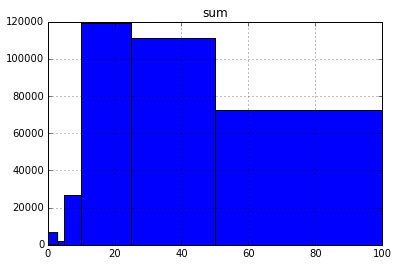

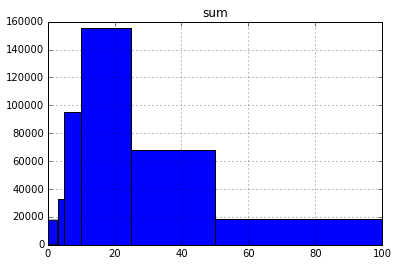

In [98]:
#there are lots of zeros and the counts are very skewed. Transform by adding one and taking natural log
counts_ln = np.log(counts + 1)
print(len(counts_ln.columns))
#compare histogram of sum of a single gene for original and transformed data.
sums_counts = pd.DataFrame(counts.sum(),columns=["sum"])
sums_counts_ln = pd.DataFrame(counts_ln.sum(),columns=["sum"])

sums_counts.hist(bins=[0,3,5,10,25,50,100,200,1000])
plt.xlim([0,100])
sums_counts_ln.hist(bins=[0,3,5,10,25,50,100,200,1000])
plt.xlim([0,100])

#the transform does seem to have made it slightly less skewed, although it is still quite skewed. 

In [111]:
#I'm going to remove any columns with sums less than 20, because those are basically zero everywhere and any linear regression is just going to want to fit y=0 to it
#Plus, training models on this many columns is going to take waaaaaay too long anyway
#These genes may be impt, but I don't think linear regression on individual genes will be good for them. May be interesting after I do the clustering
counts_clean = counts_ln.loc[:,counts_ln.sum()>10]
print(len(counts_clean.columns)) #removed about 150,000 columns
counts_clean.head()

246092


OM-RGC_ID,OM-RGC.v1.006028391,OM-RGC.v1.004149697,OM-RGC.v1.000388757,OM-RGC.v1.005449879,OM-RGC.v1.000502757,OM-RGC.v1.003523165,OM-RGC.v1.011613553,OM-RGC.v1.031994123,OM-RGC.v1.026939477,OM-RGC.v1.000323809,...,OM-RGC.v1.001896262,OM-RGC.v1.013362931,OM-RGC.v1.013029667,OM-RGC.v1.039640078,OM-RGC.v1.025796442,OM-RGC.v1.025289356,OM-RGC.v1.014294447,OM-RGC.v1.016724470,OM-RGC.v1.004238240,OM-RGC.v1.016875164
TARA_100_DCM_0.22-3,0.000000,0,0.086046,0,0.000000,0.080043,0.000000,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_100_MES_0.22-3,0.000000,0,0.015245,0,0.044412,0.000000,0.066870,0,0,0.000000,...,2.941638,2.262971,2.470113,2.119737,2.575063,2.923448,3.166705,1.856272,2.821422,2.408605
TARA_100_SRF_0.22-3,0.000000,0,0.000000,0,0.015770,0.000000,0.000000,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_102_DCM_0.22-3,0.231623,0,0.013793,0,0.000000,0.000000,0.125895,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TARA_102_MES_0.22-3,0.249582,0,0.089644,0,0.196637,0.257079,0.242051,0,0,0.076426,...,0.774463,0.340927,0.917758,0.000000,0.515102,0.000000,0.074328,0.751988,0.869943,1.601283


#### Randomly subset 1% of columns of count data, because even with this much reduced number of columns it will take too long to train

In [117]:
counts_subset = counts_clean.sample(frac=0.01,replace=False,random_state=1201,axis=1)
print(len(counts_subset.columns),len(counts_clean.columns))

(2461, 246092)


## Merge count data with metadata table by sample ID. 

Will now have df with 107 rows (sample IDs), 33 columns from metadata and the rest OMRGC genes


In [119]:
data = metadata_clean2.merge(counts_clean,right_index=True,left_on="sample.label",how="inner")
print(len(data.columns))

data_subset = metadata_clean2.merge(counts_subset,right_index=True,left_on="sample.label",how="inner")
print(len(data_subset.columns))
data_subset.head()

246125
2494


,sample.label,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,NO2 [umol/L]**,...,OM-RGC.v1.022722369,OM-RGC.v1.019935251,OM-RGC.v1.018836573,OM-RGC.v1.006164569,OM-RGC.v1.038356533,OM-RGC.v1.019746862,OM-RGC.v1.020318684,OM-RGC.v1.003190522,OM-RGC.v1.029071417,OM-RGC.v1.009109377
7,TARA_018_SRF_0.22-1.6,TARA_A100000164,11/2/09 8:18,35.76,14.26,5.4,21.4,37.9,207.8,0.02,...,0,0,0,0.000000,0.000000,0,0,0.177681,0,0
8,TARA_023_DCM_0.22-1.6,TARA_E500000081,11/18/09 12:42,42.17,17.72,55.2,15.7,38.4,224.3,0.01,...,0,0,0,0.000000,0.000000,0,0,0.082303,0,0
9,TARA_023_SRF_0.22-1.6,TARA_E500000075,11/18/09 8:23,42.21,17.71,5.5,17.6,38.2,220.0,0.01,...,0,0,0,0.000000,0.494019,0,0,0.000000,0,0
11,TARA_025_SRF_0.22-1.6,TARA_E500000178,11/23/09 9:14,39.39,19.39,5.5,18.3,38.2,218.0,0.00,...,0,0,0,0.026189,1.482236,0,0,0.000000,0,0
12,TARA_030_DCM_0.22-1.6,TARA_A100001011,12/15/09 16:17,33.93,32.77,69.1,19.0,39.3,218.1,0.01,...,0,0,0,0.055804,0.523248,0,0,0.000000,0,0


# Train some models

I'm going to take three modeling approaches, of varying degrees of naiveness, to predict gene abundance from site information (I'm calling it environmental info, although it includes cell counts and measures of diversity as well). I'll train a model for each gene in the OM-RGC, and look at its performance on the aggregate for individual genes in general. The three approaches are:

* Naive simple regression model of temperature vs. gene abundance

* Naive multiple regression model of all_features vs. gene abundance

* Select features using Lasso regularized regression, train regression model with selected features



## Split data into training and test sets

Going to do 85/15 split. 

In [121]:
train, test = skl.cross_validation.train_test_split(data, test_size=0.15, random_state=1303)
print(len(train),len(test))
#sort in order of latitude, then by longitude, in case want to plot later
train = train.sort(["Mean_Lat*","Mean_Long*"])
test = test.sort(["Mean_Lat*","Mean_Long*"])

train_subset, test_subset = skl.cross_validation.train_test_split(data_subset, test_size=0.15, random_state=1303)
print(len(train),len(test))
#sort in order of latitude, then by longitude, in case want to plot later
train_subset = train_subset.sort(["Mean_Lat*","Mean_Long*"])
test_subset = test_subset.sort(["Mean_Lat*","Mean_Long*"])

(90, 17)
(90, 17)


## Simple regression model

I'm going to do this on the subset data.

In [122]:
simple_reg = skl.linear_model.LinearRegression()


In [123]:
#for each gene in data df 
#train simple reg, calculate rss on test data, store coefficient for temp and rss in df 
simple_reg_result = pd.DataFrame(columns=["gene","simple_coef","simple_rss","R2"])
for i in range(0,len(data_subset.columns[33:])):
    gene = data_subset.columns.values[i+33]
    #train model
    mod = simple_reg.fit(X=train_subset[["Mean_Temperature [deg C]*"]],y=train_subset[[gene]])
    coef = mod.coef_
    #predict on test data using mod, calculate rss
    predict = pd.DataFrame({"gene_count":test_subset[gene]})
    predict["gene_count_pred"] = mod.predict(X=test_subset[["Mean_Temperature [deg C]*"]])
    predict["rs"] = (predict["gene_count"] - predict["gene_count_pred"])**2
    test_rss = sum(predict["rs"])
    R2 = mod.score(X=test_subset[["Mean_Temperature [deg C]*"]],y=test_subset[gene])
    simple_reg_result.loc[i] = [gene,coef,test_rss,R2]

{'boxes': [<matplotlib.lines.Line2D at 0x1a13d4990>],
 'caps': [<matplotlib.lines.Line2D at 0x1a13e4890>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a13f1b90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a13f1550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a13d4b50>,
  <matplotlib.lines.Line2D at 0x1a13e4250>]}

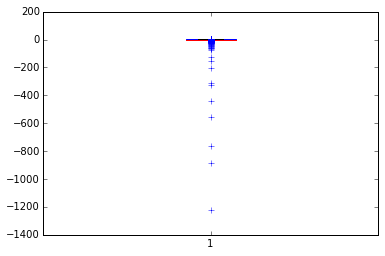

In [143]:
plt.boxplot(simple_reg_result["R2"])


{'boxes': [<matplotlib.lines.Line2D at 0x1a5fd4490>],
 'caps': [<matplotlib.lines.Line2D at 0x1a5fd4e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1503a50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a1503650>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a5fd4610>,
  <matplotlib.lines.Line2D at 0x1a5fd4a10>]}

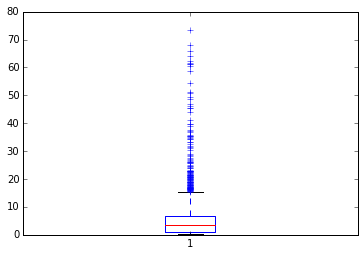

In [141]:
plt.boxplot(simple_reg_result["simple_rss"])

We can see from the boxplots that the linear regressions don't look good at all - scores are mostly negative (!), rss is pretty low, but only because the values are low. 

This is probably because there are still lots of genes (columns) that are mostly zero at almost all sites, which will result in a nearly-zero coefficient that is pretty meaningless. 

These rare genes are probably important, but a linear regression approach isn't going to work well for this analysis. 

For the sake of today, I'm going to go back and look at just genes that are reasonably abundant.

# Select new data for abundant genes

1809


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5a26a10>]], dtype=object)

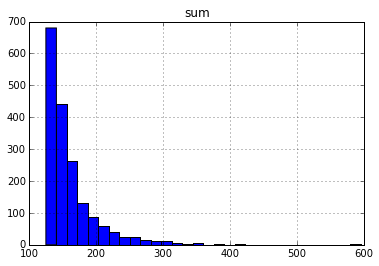

In [177]:
counts_abun = counts_ln.loc[:,counts_ln.sum()>125]
print(len(counts_abun.columns)) #removed about 150,000 columns
counts_abun.head()

sums_abun = pd.DataFrame(counts_abun.sum(),columns=["sum"])

sums_abun.hist(bins=30)

In [181]:
data_abun = metadata_clean2.merge(counts_abun,right_index=True,left_on="sample.label",how="inner")
print(len(data.columns))

data_abun.head()

246125


,sample.label,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,NO2 [umol/L]**,...,OM-RGC.v1.030626932,OM-RGC.v1.025165151,OM-RGC.v1.016280628,OM-RGC.v1.025668564,OM-RGC.v1.024293424,OM-RGC.v1.009982772,OM-RGC.v1.017183671,OM-RGC.v1.005233300,OM-RGC.v1.035148622,OM-RGC.v1.038881591
7,TARA_018_SRF_0.22-1.6,TARA_A100000164,11/2/09 8:18,35.76,14.26,5.4,21.4,37.9,207.8,0.02,...,0,0,0.000000,0,0.194672,0.224944,1.792183,0,0.989718,0
8,TARA_023_DCM_0.22-1.6,TARA_E500000081,11/18/09 12:42,42.17,17.72,55.2,15.7,38.4,224.3,0.01,...,0,0,0.000000,0,0.000000,0.088619,1.243785,0,0.339868,0
9,TARA_023_SRF_0.22-1.6,TARA_E500000075,11/18/09 8:23,42.21,17.71,5.5,17.6,38.2,220.0,0.01,...,0,0,0.000000,0,0.000000,0.000000,0.511851,0,0.036136,0
11,TARA_025_SRF_0.22-1.6,TARA_E500000178,11/23/09 9:14,39.39,19.39,5.5,18.3,38.2,218.0,0.00,...,0,0,0.150591,0,0.000000,0.000000,0.267092,0,0.382992,0
12,TARA_030_DCM_0.22-1.6,TARA_A100001011,12/15/09 16:17,33.93,32.77,69.1,19.0,39.3,218.1,0.01,...,0,0,0.000000,0,0.000000,0.000000,1.779962,0,0.000000,0


In [182]:
train_abun, test_abun = skl.cross_validation.train_test_split(data_abun, test_size=0.15, random_state=1303)
print(len(train_abun),len(test_abun))
#sort in order of latitude, then by longitude, in case want to plot later
train_abun = train_abun.sort(["Mean_Lat*","Mean_Long*"])
test_abun = test_abun.sort(["Mean_Lat*","Mean_Long*"])

(90, 17)


## Try the simple regression model with the abun data

In [183]:
simple_reg = skl.linear_model.LinearRegression()
#for each gene in data df 
#train simple reg, calculate rss on test data, store coefficient for temp and rss in df 
simple_reg_result = pd.DataFrame(columns=["gene","simple_coef","simple_rss","R2"])
for i in range(0,len(data_abun.columns[33:])):
    gene = data_abun.columns.values[i+33]
    #train model
    mod = simple_reg.fit(X=train_abun[["Mean_Temperature [deg C]*"]],y=train_abun[[gene]])
    coef = mod.coef_
    #predict on test data using mod, calculate rss
    predict = pd.DataFrame({"gene_count":test_abun[gene]})
    predict["gene_count_pred"] = mod.predict(X=test_abun[["Mean_Temperature [deg C]*"]])
    predict["rs"] = (predict["gene_count"] - predict["gene_count_pred"])**2
    test_rss = sum(predict["rs"])
    R2 = mod.score(X=test_abun[["Mean_Temperature [deg C]*"]],y=test_abun[gene])
    simple_reg_result.loc[i] = [gene,coef,test_rss,R2]

{'boxes': [<matplotlib.lines.Line2D at 0x1b958af90>],
 'caps': [<matplotlib.lines.Line2D at 0x1b9596e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b95af190>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1b95a2b10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1b9596150>,
  <matplotlib.lines.Line2D at 0x1b9596810>]}

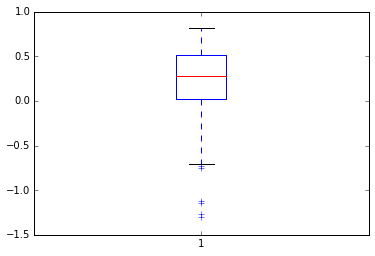

In [184]:
plt.boxplot(simple_reg_result["R2"])


{'boxes': [<matplotlib.lines.Line2D at 0x1d5efd810>],
 'caps': [<matplotlib.lines.Line2D at 0x1d5f0a690>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d5f16990>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d5f16350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d5efd9d0>,
  <matplotlib.lines.Line2D at 0x1d5f0a050>]}

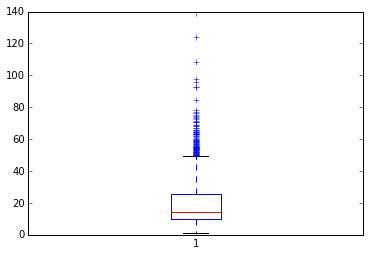

In [187]:
plt.boxplot(simple_reg_result["simple_rss"])

This looks much more reasonable. Let's continue using the abundant gene dataset, try some other regression modeling approaches and see if we can improve performance.

## Naive all_features model

In [188]:
all_features = ['Mean_Lat*', 'Mean_Long*', 'Mean_Depth [m]*',
       'Mean_Temperature [deg C]*', 'Mean_Salinity [PSU]*',
       'Mean_Oxygen [umol/kg]*', 'NO2 [umol/L]**', 'PO4 [umol/L]**',
       'NO2NO3 [umol/L]**', 'SI [umol/L]**', 'Lyapunov_exp.', 'retention',
       'Mean Depth MLD Sigma [m]*', 'Mean Depth Max Fluo [m]*',
       'Mean Depth Max N2 [m]*', 'Mean Depth Max O2 [m]*',
       'Mean Depth Min O2 [m]*', 'miTAG.SILVA.Taxo.Richness',
       'miTAG.SILVA.Phylo.Diversity', 'miTAG.SILVA.Chao', 'miTAG.SILVA.ace',
       'miTAG.SILVA.Shannon', 'OG.Shannon', 'OG.Richness', 'OG.Evenness',
       'FC - heterotrophs [cells/mL]', 'FC - autotrophs [cells/mL]',
       'FC - bacteria [cells/mL]', 'FC - picoeukaryotes [cells/mL]',
       'minimum generation time [h]']

mult_reg = skl.linear_model.LinearRegression()

In [189]:
#for each gene in data df (data.ix[:,33:])
#train multiple reg, calculate rss on test data, store coefficients and rss in df 
allfeat_reg_result = pd.DataFrame(columns=["gene","mult_rss","R2"])
for i in range(0,len(data_abun.columns[33:])):
    gene = data_abun.columns.values[i+33]
    #train model
    mod = mult_reg.fit(X=train_abun[all_features],y=train_abun[[gene]])
    coef = mod.coef_
    #predict on test data using mod, calculate rss
    predict = pd.DataFrame({"gene_count":test_abun[gene]})
    predict["gene_count_pred"] = mod.predict(X=test_abun[all_features])
    predict["rs"] = (predict["gene_count"] - predict["gene_count_pred"])**2
    test_rss = sum(predict["rs"])
    R2 = mod.score(X=test_abun[all_features],y=test_abun[gene])
    allfeat_reg_result.loc[i] = [gene,test_rss,R2]


In [190]:
allfeat_reg_result.head()

,gene,mult_rss,R2
0,OM-RGC.v1.039421122,6.247640,0.089246
1,OM-RGC.v1.000227278,2.388898,0.107498
2,OM-RGC.v1.001692225,3.002725,0.112157
3,OM-RGC.v1.016007441,5.942176,0.081054
4,OM-RGC.v1.006528291,4.116666,0.588195


{'boxes': [<matplotlib.lines.Line2D at 0x1d64853d0>],
 'caps': [<matplotlib.lines.Line2D at 0x1d6492290>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d649c590>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d6492f10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d6485550>,
  <matplotlib.lines.Line2D at 0x1d6485c10>]}

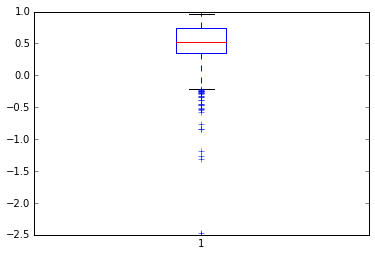

In [192]:
plt.boxplot(allfeat_reg_result["R2"])

{'boxes': [<matplotlib.lines.Line2D at 0x1d65ea0d0>],
 'caps': [<matplotlib.lines.Line2D at 0x1d65eaf50>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d65fa290>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d65edc10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d65ea250>,
  <matplotlib.lines.Line2D at 0x1d65ea910>]}

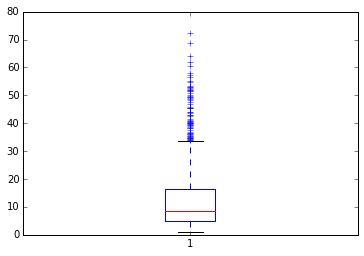

In [193]:
plt.boxplot(allfeat_reg_result["mult_rss"])

It looks like including all the features did improve performance on the test set marginally compared to the simple regression. Let's see if we can select features a little more intelligently

## Lasso feature selection using cross validation; RSS regression using selected features

### Feature selection

In [203]:
#define L1 values to try, will range from 0.1 to 100
L1 = np.logspace(-4, 5, num=20)

In [197]:
# write function to compute avg cross-validation error for given value k
#accepts k number of folds, l2_penalty, data is dataframe of input features, output is column of output values; returns average validation error
def k_fold_cross_validation(k, l1_penalty, data, output):
    n = len(data)
    rss = pd.DataFrame(columns=["iteration","val_error"])
    for i in xrange(k):
        #define start and end indices for val set from training
        start = len(data)*i/k
        end= (len(data)*(i+1)/k)-1
        #slice into val set and remaining training set
        val = data[start:end+1]
        tr = data[0:start].append(data[end+1:n])
        #train linear model with give l2_penalty
        model = skl.linear_model.Lasso(alpha=parameter, normalize=True)
        mod = model.fit(X=tr,y=output[0:start].append(output[end+1:n]))
        #use model to predict output of val set
        predict = pd.DataFrame({"output":output[start:end+1]})
        predict["output_pred"] = mod.predict(X=val)
        #compute rss for this iteration, store in df
        predict["rs"] = (predict["output"] - predict["output_pred"])**2
        val_error = sum(predict["rs"])
        rss.loc[i] = [i,val_error]
    avg_val_error = sum(rss["val_error"])/k
    return [avg_val_error]

In [247]:
#for each gene, 
#for each L1 value, train Lasso model on training, calculate cross-val RSS, choose L1 with min xval_rss; calc test rss for chosen L1, store output in df
rss = pd.DataFrame(columns=["gene","L1","test_rss"])
for i in range(0,len(data_abun.columns[33:])):
    gene = data_abun.columns.values[i+33]
    l1_error = pd.DataFrame(columns=["l1_parameter","avg_xval_error"])
    for j in range(0,len(L1)):
        parameter = L1[j]
        #use 5-fold cross validation to get xval_rss for that L1
        xval_err = k_fold_cross_validation(k=5,l1_penalty=parameter,data=train_abun[all_features],output=train_abun[gene])
        l1_error.loc[j] = [parameter,xval_err]
    #choose L1 as one with min xval error
    min = np.array(l1_error["avg_xval_error"]).min()
    l1_to_use = np.array(l1_error.loc[l1_error["avg_xval_error"]==min[0]]["avg_xval_error"])[0]
    #train model on training using l1 picked
    model = skl.linear_model.Lasso(alpha=l1_to_use, normalize=True)
    mod = model.fit(X=train_abun[all_features],y=train_abun[gene])
    #make predictions on test data, calculate RSS 
    predict = pd.DataFrame({"output":test_abun[gene]})
    predict["output_pred"] = mod.predict(X=test_abun[all_features])
    predict["rs"] = (predict["output"] - predict["output_pred"])**2
    test_error = sum(predict["rs"])
    rss.loc[i] = [gene,l1_to_use,test_error]

In [248]:
rss.head()

,gene,L1,test_rss
0,OM-RGC.v1.039421122,[4.78165290667],6.874016
1,OM-RGC.v1.000227278,[3.79898482057],2.737531
2,OM-RGC.v1.001692225,[4.36741138179],3.830545
3,OM-RGC.v1.016007441,[16.5527327537],7.601432
4,OM-RGC.v1.006528291,[11.906607223],11.359380


In [ ]:
#allfeat_df = pd.DataFrame({"feature":all_features,"coef":mod.coef_})
#allfeat_df["coef_binary"] = allfeat_df["coef"]>0
#allfeat_df["coef_binary"] = allfeat_df["coef_binary"].astype(int)
#allfeat_df["coef_binary"]

It's choosing as small of L1 values as I will give it, but this is because *all* of the feature parameters are zero. 

Basically, the genes I'm looking at are just too sparse to see any linear regression pattern. This looks to be the case in all of these models. 

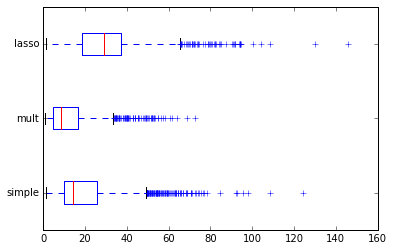

In [274]:
performance = pd.concat([simple_reg_result["simple_rss"],allfeat_reg_result["mult_rss"],rss["test_rss"]], axis=1)
#plt.boxplot(performance["simple_rss"])
totfigs = ["simple","mult","lasso"]

plt.figure()
plt.hold = True
boxes=[]
for column in performance:    
    x = performance[column]
    boxes.append(x)

plt.boxplot(boxes,vert=0,labels=totfigs)
plt.show()

#ggplot(aes(x=1,y="simple_rss"),data=performance) + geom_boxplot() + geom_boxplot(aes(x=2,y="test_rss",),color="green")

It's interesting that Lasso gave higher test error, when the L1s that were chosen weren't the minimum values tested (that would push it toward the multiple regression result). This may be because of the low n, but I'm not sure what would cause this result, I'll need to look into what's causing this further. 

## A note on feature engineering and feature selection with Lasso

We have a *lot* of features for the amount of data we have, only about 107 complete observations. This is going to make us especially prone to overfitting. 

But, a lot of those features are intra-correlated (nutrients, cell counts, diversity measures, etc.). So, some feature engineering may be called for to reduce the number of features. With some domain knowledge, we may be able to combine them into a smaller number of features in a useful way. We could also try a dimension reduction step in the features first, like using the first three or so dimensions of the PCA-filtered features. 

I used Lasso to select among all these features, which is a reasonable strategy, but an important thing to note is that for features that are intra-correlated, Lasso will pick between those features pretty much arbitrarily, especially for this small of a sample size. I could look into elastic net regularization instead, which can handle the large p, small n problem better than lasso in many cases.

Another approach I'd like to try is something like a decision tree, which I could see picking up on an environmental niche better than regression and resulting in better predictions. It may also do better with genes that are zero at many stations. 

I also think that linear regression models will probably do better once I've done the unsupervised clustering of genes, and I'm predicting abundance of clusters rather than individual genes, because there won't be so many zeros in the dependent variable.